In [1]:
# %matplotlib ipympl
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as imageio
from skimage.draw import disk
# import helper_functions
import scipy.ndimage as ndimagey
import re
from multiprocessing import Pool

# helper_functions.set_style(shift=-8)

In [3]:
#My function

import SimpleITK as sitk
import numpy as np

def save_nifti(array, filename):
    """
    Save a 2D or 3D NumPy array as a NIFTI file using SimpleITK.

    Parameters:A
    - array: NumPy array (2D or 3D) to be saved.
    - filename: Path to the NIFTI file where the array will be saved.
    """
    # Convert NumPy array to SimpleITK image
    image = sitk.GetImageFromArray(array)
    
    # Save the image as a NIFTI file
    sitk.WriteImage(image, filename)
    
import SimpleITK as sitk

def load_nifti(filename):
    """
    Load a NIFTI file and convert it to a NumPy array using SimpleITK.

    Parameters:
    - filename: Path to the NIFTI file to be loaded.

    Returns:
    - NumPy array representation of the NIFTI file.
    """
    # Read the NIFTI file into a SimpleITK image
    image = sitk.ReadImage(filename)
    
    # Convert the SimpleITK image to a NumPy array
    array = sitk.GetArrayFromImage(image)
    
    return array



In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
import cupy as cp
import cupyx.scipy.ndimage as cu_ndimage
mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

# Creates the rotation matrix and translation vector
# I arrived at this through a mix of trail and error and StackOverflow
def create_ridgid_transform(transform_params, center_of_rotation):
    R = nib.eulerangles.euler2mat(transform_params[2],
                                  transform_params[1],
                                  transform_params[0])
    R = np.linalg.inv(R)
    c = np.asarray(center_of_rotation)
    t = np.asarray([transform_params[5], transform_params[4], transform_params[3]])
    offset = -(c - c.dot(R)).dot(np.linalg.inv(R))
    T = t + offset

    return R, T

# It is much faster to use GPU compared to CPU
def rigid_transform_gpu(arr, R, T, gpu_idx=0, cval=0):
    with cp.cuda.Device(gpu_idx):
        tmp = cu_ndimage.affine_transform(cp.asarray(arr), cp.asarray(R),
                                          offset=cp.asarray(T), output_shape=arr.shape,
                                          mode='constant', cval=cval).get()
        mempool.free_all_blocks()
    return tmp

def colorbar(mappable, title=None, format=None, shift=None):
    if shift is not None:
        set_style(shift)
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax, format=format)
    plt.sca(last_axes)
    if title is not None:
        cbar.set_label(title)
    return cbar

In [5]:
# Create original_volume
original_volume = np.zeros([1000, 1000, 1000], dtype=np.uint16)

centre = (499, 499)
radius = 300
rr, cc = disk(center=centre, radius=radius, shape=(1000, 1000))
original_volume[100:-100, rr, cc] = 1
original_volume_mask = np.copy(original_volume)

rng = np.random.default_rng(seed=137)
original_volume[original_volume == 1] = rng.normal(loc=2e4, scale=2500, size=original_volume[original_volume == 1].size)

rr, cc = disk(center=centre, radius=30, shape=(1000, 1000))
original_volume[100:-100, rr, cc] += 15000

In [6]:
# save_as_nifti(original_volume,'test_fixed.nii')

In [6]:
# Create a moved_volume
moved_volume = np.zeros([1000, 1000, 1000], dtype=np.uint16)

shift_x = 13
shift_y = -7
shift_z = 3
centre = (499+shift_x, 499+shift_y)
radius = 300
rr, cc = disk(center=centre, radius=radius, shape=(1000, 1000))
moved_volume[100+shift_z:-100+shift_z, rr, cc] = 1
moved_volume_mask = np.copy(moved_volume)

rng = np.random.default_rng(seed=137)
moved_volume[moved_volume == 1] = rng.normal(loc=2e4, scale=2500, size=moved_volume[moved_volume == 1].size)

rr, cc = disk(center=centre, radius=30, shape=(1000, 1000))
moved_volume[100+shift_z:-100+shift_z, rr, cc] += 15000

In [8]:
# save_as_nifti(moved_volume,'test_moved.nii')

In [9]:
# # Rotate the volume, I do this for each slice individually
# def rotate_volume(iSlice):
#     return ndimage.rotate(moved_volume[:, iSlice], 10, axes=(0, 1), reshape=False)

# slices = [iSlice for iSlice in range(1000)]
# i=0
# with Pool() as p:
#     i+=1
#     print(i)
#     results = p.map(rotate_volume, slices)

In [10]:
# Move some axis around
# moved_volume = np.moveaxis(np.asarray(results).astype(np.uint16), 0, 1)

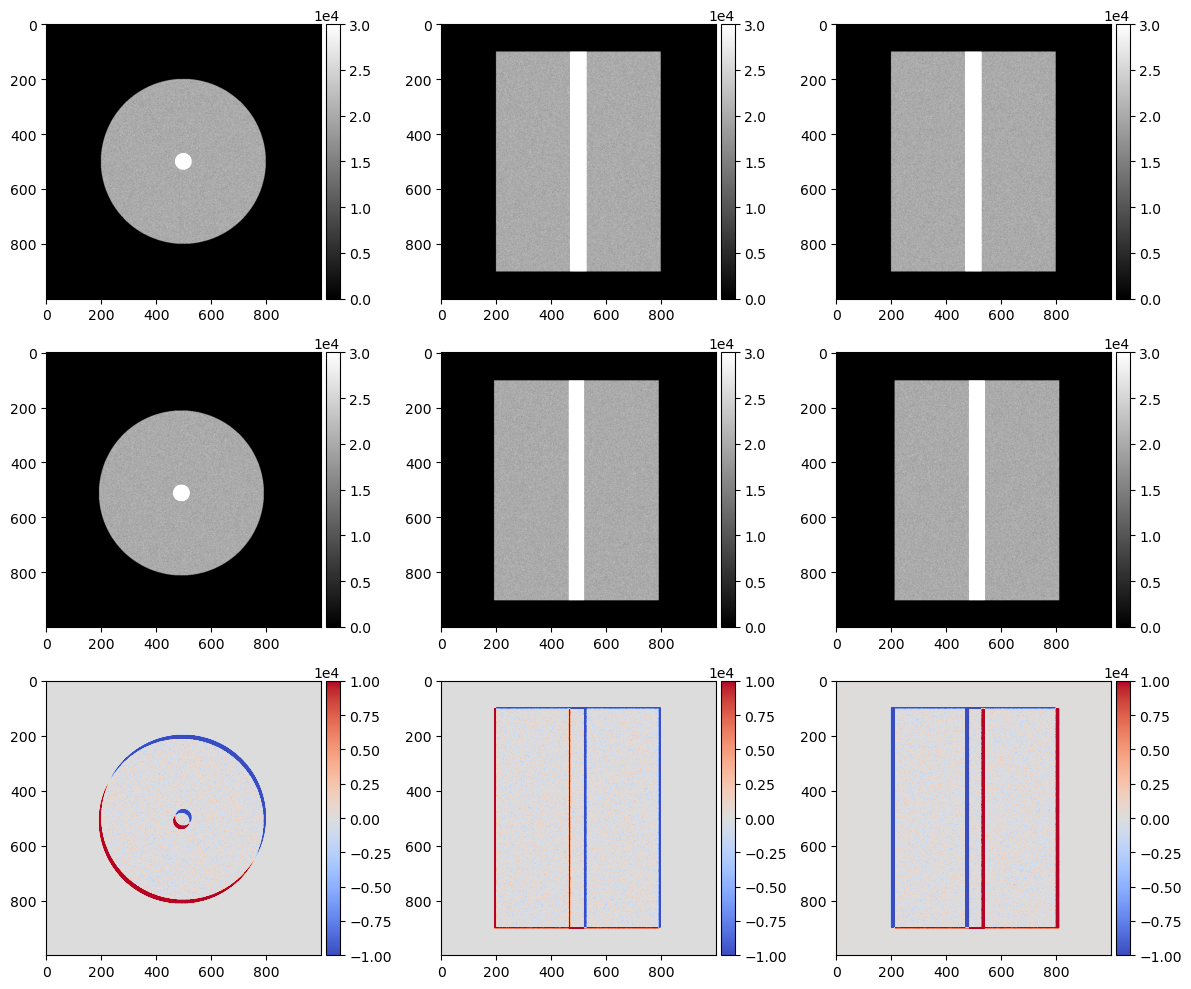

In [7]:
# Plots
iSlice = 500

fig, ax = plt.subplots(3, 3, squeeze=False, figsize=(12, 10))
im = ax[0, 0].imshow(original_volume[iSlice], vmin=0, vmax=3e4, cmap='gray')
cbar = colorbar(im)
cbar.formatter.set_powerlimits((0, 0))
im = ax[0, 1].imshow(original_volume[:, iSlice], vmin=0, vmax=3e4, cmap='gray')
cbar = colorbar(im)
cbar.formatter.set_powerlimits((0, 0))
im = ax[0, 2].imshow(original_volume[:, :, iSlice], vmin=0, vmax=3e4, cmap='gray')
cbar = colorbar(im)
cbar.formatter.set_powerlimits((0, 0))

im = ax[1, 0].imshow(moved_volume[iSlice], vmin=0, vmax=3e4, cmap='gray')
cbar = colorbar(im)
cbar.formatter.set_powerlimits((0, 0))
im = ax[1, 1].imshow(moved_volume[:, iSlice], vmin=0, vmax=3e4, cmap='gray')
cbar = colorbar(im)
cbar.formatter.set_powerlimits((0, 0))
im = ax[1, 2].imshow(moved_volume[:, :, iSlice], vmin=0, vmax=3e4, cmap='gray')
cbar = colorbar(im)
cbar.formatter.set_powerlimits((0, 0))

im = ax[2, 0].imshow(moved_volume[iSlice].astype(np.float32) - original_volume[iSlice].astype(np.float32), cmap='coolwarm', vmin=-10000, vmax=10000)
cbar = colorbar(im)
cbar.formatter.set_powerlimits((0, 0))
im = ax[2, 1].imshow(moved_volume[:, iSlice].astype(np.float32) - original_volume[:, iSlice].astype(np.float32), cmap='coolwarm', vmin=-10000, vmax=10000)
cbar = colorbar(im)
cbar.formatter.set_powerlimits((0, 0))
im = ax[2, 2].imshow(moved_volume[:, :, iSlice].astype(np.float32) - original_volume[:, :, iSlice].astype(np.float32), cmap='coolwarm', vmin=-10000, vmax=10000)
cbar = colorbar(im)
cbar.formatter.set_powerlimits((0, 0))

fig.tight_layout()

In [12]:
# Saves the volumes. Replace this folder with your own.
file_path = '/work3/awias/MicroCracks/'
file_name = 'original_volume.tiff'
imageio.imwrite(file_path+file_name, original_volume)
file_name = 'original_volume_mask.tiff'
imageio.imwrite(file_path+file_name, original_volume_mask)

file_name = 'moved_volume.tiff'
imageio.imwrite(file_path+file_name, moved_volume)
file_name = 'moved_volume_mask.tiff'
imageio.imwrite(file_path+file_name, moved_volume_mask)

Run `export LD_LIBRARY_PATH=/dtu/3d-imaging-center/QIM/elastix/elastix-4.9.0/lib/:$LD_LIBRARY_PATH` in your terminal to get elastix in your path then you will be able to run it from the terminal. After which you can run the command below. Remember to change your paths.

`elastix -f "/dtu/3d-imaging-center/projects/2022_QIM_DisCO2/raw_data_3DIM/Elastix_Test/original_volume.tif" -m "/dtu/3d-imaging-center/projects/2022_QIM_DisCO2/raw_data_3DIM/Elastix_Test/moved_volume.tif" -fMask "/dtu/3d-imaging-center/projects/2022_QIM_DisCO2/raw_data_3DIM/Elastix_Test/original_volume.tif" -mMask "/dtu/3d-imaging-center/projects/2022_QIM_DisCO2/raw_data_3DIM/Elastix_Test/moved_volume.tif" -out "/dtu/3d-imaging-center/projects/2022_QIM_DisCO2/raw_data_3DIM/Elastix_Test/" -p "/work3/pwra/DisCO2/HCl_experiment/elastix_registration/parameterFile.txt"`

In [ ]:
# Read the transformation parameters and the center of rotation from the output of Elastix.

file_path = '/dtu/3d-imaging-center/projects/2022_QIM_DisCO2/raw_data_3DIM/Elastix_Test/'
transform_params_pattern = re.compile(r'\(TransformParameters (.+?)\)')
center_of_rotation_pattern = re.compile(r'\(CenterOfRotationPoint (.+?)\)')

with open(file_path+'TransformParameters.0.txt') as f:
    print(f'Opening file {file_path}TransformParameters.0.txt')
    text = f.read().replace('\n', '')
        
# Extract TransformParameters
transform_params_match = transform_params_pattern.search(text)
if transform_params_match:
    transform_params = list(map(float, transform_params_match.group(1).split()))
    print("Transform Parameters:", transform_params)

# Extract CenterOfRotationPoint
center_of_rotation_match = center_of_rotation_pattern.search(text)
if center_of_rotation_match:
    center_of_rotation = list(map(float, center_of_rotation_match.group(1).split()))
    print("Center of Rotation Point:", center_of_rotation)

In [ ]:
# Create and apply the transformation

R, T = create_ridgid_transform(transform_params, center_of_rotation)
print(R, T)

rotated_volume = rigid_transform_gpu(moved_volume, R, T, gpu_idx=2)

In [ ]:
# Results

fig, ax = plt.subplots(3, 3, squeeze=False, figsize=(12, 12))
ax[0, 0].imshow(original_volume[500], vmin=0, vmax=3e4, cmap='gray')
ax[0, 1].imshow(original_volume[:, 500], vmin=0, vmax=3e4, cmap='gray')
ax[0, 2].imshow(original_volume[:, :, 500], vmin=0, vmax=3e4, cmap='gray')
ax[1, 0].imshow(moved_volume[500], vmin=0, vmax=3e4, cmap='gray')
ax[1, 1].imshow(moved_volume[:, 500], vmin=0, vmax=3e4, cmap='gray')
ax[1, 2].imshow(moved_volume[:, :, 500], vmin=0, vmax=3e4, cmap='gray')
ax[2, 0].imshow(rotated_volume[500], vmin=0, vmax=3e4, cmap='gray')
ax[2, 1].imshow(rotated_volume[:, 500], vmin=0, vmax=3e4, cmap='gray')
ax[2, 2].imshow(rotated_volume[:, :, 500], vmin=0, vmax=3e4, cmap='gray')
fig.tight_layout()

In [ ]:
# More results, it's not quite perfect but pretty close.

fig, ax = plt.subplots(2, 3, squeeze=False, figsize=(12, 8))
# Difference before co-registration
ax[0, 0].imshow(original_volume[500].astype(np.float32) - moved_volume[500].astype(np.float32),
                vmin=-1e4, vmax=1e4, cmap='coolwarm')
ax[0, 1].imshow(original_volume[:, 500].astype(np.float32) - moved_volume[:, 500].astype(np.float32),
                vmin=-1e4, vmax=1e4, cmap='coolwarm')
ax[0, 2].imshow(original_volume[:, :, 500].astype(np.float32) - moved_volume[:, :, 500].astype(np.float32),
                vmin=-1e4, vmax=1e4, cmap='coolwarm')
# Difference after co-registration
ax[1, 0].imshow(original_volume[500].astype(np.float32) - rotated_volume[500].astype(np.float32),
                vmin=-1e4, vmax=1e4, cmap='coolwarm')
ax[1, 1].imshow(original_volume[:, 500].astype(np.float32) - rotated_volume[:, 500].astype(np.float32),
                vmin=-1e4, vmax=1e4, cmap='coolwarm')
ax[1, 2].imshow(original_volume[:, :, 500].astype(np.float32) - rotated_volume[:, :, 500].astype(np.float32),
                vmin=-1e4, vmax=1e4, cmap='coolwarm')
fig.tight_layout()